In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv


# **Updating/Instaling Libraries**

In [29]:
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

In [30]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 


from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from keras.layers import MaxPool1D

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# **Loading Dataset**

In [31]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [32]:

df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
display(df_train)
df_train.head()
df_train.describe()
df_train.info()
print(df_train.category.unique())

,category,text,cleanText,count
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
 3   count      98883 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


In [33]:
display(df_test)
df_test.head()
df_test.describe()
df_test.info()

,category,text,cleanText,count
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   count      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [34]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

# **Stopwords Removal**

In [35]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
display(data1)
stop = data1['words'].tolist()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [36]:
#df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))


In [37]:
#df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [38]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [39]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

# **Changing Labels to Numbers**

In [40]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

df_train["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
df_test["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,1,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,1,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,6,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,5,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,4,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,4,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


# **Removing Null values**

In [41]:
#display non-null values
df_train = df_train.dropna()
df_test = df_test.dropna()

# **Removing Small Texts**

In [42]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>5]
df_test= df_test.loc[df_test['count']>5]

# **Shuffle Dataset**

In [43]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,ফেব্রুয়ারি মাসে সাধারণ মূল্যস্ফীতি কিছুটা কমেছ...,ফেব্রুয়ারি মাসে সাধারণ মূল্যস্ফীতি ...,103
1,0,বিদেশি উন্নয়ন সহায়তা আরও কার্যকরভাবে ব্যবহার ক...,বিদেশি উন্নয়ন সহায়তা কার্যকরভাবে ...,416
2,2,"বিশ্বজুড়ে নাচ, গান, বর্ণিল আতশবাজির খেলাসহ নান...",বিশ্বজুড়ে নাচ গান বর্ণিল আতশবাজি...,114
3,5,"ওজন নয়, রোজগার। গত বছর থেকে এ বছর ৪০ মিলিয়ন পা...",ওজন রোজগার বছর বছর মিলিয়ন পাউ...,101
4,0,পুঁজিবাজারে তালিকাভুক্ত ব্যাংকিং খাতের কোম্পান...,পুঁজিবাজারে তালিকাভুক্ত ব্যাংকিং খা...,91
...,...,...,...,...
98620,3,চট্টগ্রামে এক পুলিশ কর্মকর্তার বিরুদ্ধে তাঁর স...,চট্টগ্রামে পুলিশ কর্মকর্তার বিরুদ্ধ...,229
98621,6,ঢাকা বিশ্ববিদ্যালয়ের ২০১৭-১৮ শিক্ষাবর্ষে ব্য...,ঢাকা বিশ্ববিদ্যালয়ের শিক্ষাবর্ষে ব্...,132
98622,1,আজ টেলিভিশনের পর্দায় যে খেলাগুলো দেখবেনফ্রেঞ্চ...,টেলিভিশনের পর্দায় খেলাগুলো দেখবেনফ্...,34
98623,2,"জার্মানির চ্যান্সেলর অ্যাঙ্গেলা মেরকেল বলেছেন,...",জার্মানির চ্যান্সেলর অ্যাঙ্গেলা মের...,67


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


In [44]:
train_sentences=df_train['cleanText'].values
train_labels=df_train['category'].values

In [45]:
test_sentences=df_test['cleanText'].values
test_labels=df_test['category'].values

In [46]:
print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 98625
Testing Set Length: 98602
train_labels shape: (98625,)
test_labels shape: (98602,)


# **Train/Test/Validation Set**
**This dataset contains two csv files. One is Train set and another is Test set.IN EDA,we have seen that train and test set is equal sized and distribution of class is identical to both of the test and train set.
I have used full train set for training and used 20% of the data from testset for validation set and 80% for testing
The validation set and the Test set is partitioned into stratified fashion to keep the distribution of class intact.**

In [47]:
test_sentences, validation_sentences,test_labels, validation_labels = train_test_split(test_sentences, test_labels,stratify=test_labels,test_size=0.2)

In [48]:
train_labels=keras.utils.to_categorical(train_labels)
test_labels=keras.utils.to_categorical(test_labels)
validation_labels=keras.utils.to_categorical(validation_labels)


print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("validation_sentences shape: "+str(validation_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 98625
Testing Set Length: 98602
training_sentences shape: (98625,)
testing_sentences shape: (78881,)
validation_sentences shape: (19721,)
train_labels shape: (98625, 7)
test_labels shape: (78881, 7)
validation_labels shape: (19721, 7)


In [49]:
print(train_sentences[1])
print(train_labels[0])

  বিদেশি    উন্নয়ন    সহায়তা    কার্যকরভাবে    প্রথমবারের    জাতীয়    নীতিমালা    তৈরি    সরকার    ইতিমধ্যে    অর্থনৈতিক    সম্পর্ক    বিভাগ    ইআরডি    বিষয়ে    প্রাথমিক    খসড়াও    তৈরি    খসড়ায়    পাঁচটি    উদ্দেশ্যে    নীতিমালাটি    তৈরি    কথা    উদ্দেশ্যগুলো    হলোউন্নয়ন    সহযোগিতার    সুসংহত    কৌশলগত    পদ্ধতি    উপস্থাপন    বৈদেশিক    সহায়তার    কার্যকর    নিশ্চিতকরণ    জাতীয়    উন্নয়ন    অগ্রাধিকার    জাতীয়    পদ্ধতির    উন্নয়ন    সহযোগীদের    নীতি    পদ্ধতির    সামঞ্জস্য    বিধান    অন্তর্ভুক্তিমূলক    অংশীদারত্ব    সৃষ্টিতে    সহযোগিতা    প্রদান    বৈদেশিক    সহায়তা    আহরণে    জাতীয়    সক্ষমতা    বৃদ্ধি    খসড়াটির    ওপর    ইআরডি    সংশ্লিষ্ট    মন্ত্রণালয়ের    উন্নয়ন    সহযোগীদের    পরামর্শক    সভা    বছরের    মার্চ    মাসের    এসব    পরামর্শক    সভা    শেষ    খসড়াটি    অনুমোদনের    মন্ত্রিপরিষদ    বিভাগে    পাঠানো    এরপর    জুন    মাসের    নীতিমালা    চূড়ান্ত    অনুমোদন    অর্থবছর    উন্নয়ন    সহযোগী    দাতারা    বাংলাদেশকে    মোট    হাজার    কোটি    ডলার    পাইপলাইনে

# **Tokenization**

In [50]:
vocab_size = 100000
embedding_dim = 150
max_length = 600
trunc_type='post'
oov_tok = "<OOV>"

print(train_sentences.shape)
print(train_labels.shape)


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#464246 words in raw dataset
#463651 words in raw dataset after stopwords removal
#***** after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

(98625,)
(98625, 7)
464230
Word index length:464230


# **After Tokenization Data visualization**

In [51]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

  বিশ্বজুড়ে    নাচ    গান    বর্ণিল    আতশবাজির    খেলাসহ    আয়োজনে    স্বাগত    জানানো    হলো    খ্রিষ্টীয়    নতুন    বছরকে    চীনে    বর্ষবরণের    অনুষ্ঠান    বিষাদে    পরিণত    সাংহাইয়ের    চেনি    স্কয়ারে    বর্ষবরণের    আয়োজনে    যোগ    ভিড়ে    চাপা    পড়ে    মৃত্যু    খবর    বিবিসির    সাংহাইয়ের    চেনি    স্কয়ারে    সালকে    বিদায়    হুয়াংপু    নদীর    তীরে    নতুন    বছরের    প্রথম    সূর্যোদয়    দেখার    সালকে    স্বাগত    জানাতে    হাজির    হয়েছিলেন    হাজারো    মানুষ    সামাজিক    যোগাযোগের    মাধ্যমগুলোতে    নৈশক্লাবের    বারান্দা    জাল    টাকা    ছড়ানো    হচ্ছিল    কুড়িয়ে    হুড়োহুড়ি    পড়ে    চীনের    রাষ্ট্রীয়    গণমাধ্যমে    নিহত    ব্যক্তিদের    বেশির    ভাগই    শিক্ষার্থী    জনই    নারী    আছেন    এদিকে    নিউইয়র্কের    টাইমস    স্কয়ার    অস্ট্রেলিয়ার    সিডনি    হারবার    মস্কোর    সেন্ট    বাস্তিল    ক্যাথেড্রাল    বার্লিনের    ব্রান্ডেনবুর্গ    সংযুক্ত    আরব    আমিরাতের    দুবাইয়ে    আয়োজিত    বর্ষবরণের    আয়োজন    বরাবরের    মতোই 

In [52]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (98625, 600)
Padded shape(testing): (78881, 600)


# **Model Creation**

In [53]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(150, kernel_size=3, activation = "relu"))
model.add(MaxPool1D(pool_size=16))
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 150)          15000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 598, 150)          67650     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 37, 150)           0         
_________________________________________________________________
dense (Dense)                (None, 37, 20)            3020      
_________________________________________________________________
flatten (Flatten)            (None, 740)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5187      
Total params: 15,075,857
Trainable params: 15,075,857
Non-trainable params: 0
__________________________________________

In [54]:
history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=( validation_padded,validation_labels),use_multiprocessing=True, workers=8)

2021-10-19 19:22:41.073776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
386/386 [==============================] - 433s 1s/step - loss: 2.2212 - accuracy: 0.1959 - val_loss: 2.1550 - val_accuracy: 0.2655
Epoch 2/10
386/386 [==============================] - 444s 1s/step - loss: 1.9870 - accuracy: 0.4179 - val_loss: 1.6749 - val_accuracy: 0.6288
Epoch 3/10
386/386 [==============================] - 440s 1s/step - loss: 1.2941 - accuracy: 0.7212 - val_loss: 1.0157 - val_accuracy: 0.7844
Epoch 4/10
386/386 [==============================] - 442s 1s/step - loss: 0.8462 - accuracy: 0.8226 - val_loss: 0.7421 - val_accuracy: 0.8420
Epoch 5/10
386/386 [==============================] - 432s 1s/step - loss: 0.6447 - accuracy: 0.8732 - val_loss: 0.6120 - val_accuracy: 0.8789
Epoch 6/10
386/386 [==============================] - 430s 1s/step - loss: 0.5321 - accuracy: 0.9010 - val_loss: 0.5336 - val_accuracy: 0.8937
Epoch 7/10
386/386 [==============================] - 428s 1s/step - loss: 0.4564 - accuracy: 0.9175 - val_loss: 0.4804 - val_accuracy: 0.9051

# **Learning Curve**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


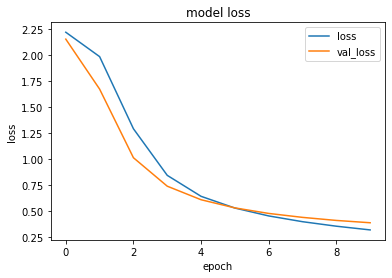

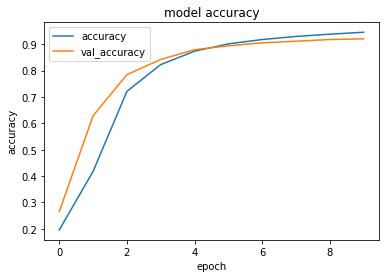

In [55]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


# **Evaluation**

In [56]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

386/386 [==============================] - 102s 264ms/step - loss: 0.3005 - accuracy: 0.9502
The train accuracy is: 0.9502357244491577
309/309 [==============================] - 91s 294ms/step - loss: 0.3891 - accuracy: 0.9189
The test accuracy is: 0.9189285039901733


In [57]:
predictions = model.predict(testing_padded)

In [58]:
predictions = np.argmax(predictions, axis=-1) 

In [59]:
test_labels=np.argmax(test_labels, axis=-1)

In [60]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels,predictions, average='weighted')
print("Precision :"+str(precision))
print("Recall :"+str(recall))
print("fscore :"+str(fscore))

Precision :0.9189906541746071
Recall :0.9189285125695669
fscore :0.9189339404261028


# **Confusion Matrix & Classification Report**

,precision,recall,f1-score,support
economy,90.00,89.59,89.79,11584.000000
sports,98.74,97.55,98.14,12693.000000
international,91.22,93.02,92.11,12250.000000
state,88.20,87.87,88.04,12146.000000
technology,88.16,87.30,87.73,7948.000000
entertainment,93.44,94.26,93.85,12194.000000
education,91.84,91.65,91.74,10066.000000
accuracy,91.89,91.89,91.89,0.918929
macro avg,91.66,91.61,91.63,78881.000000
weighted avg,91.90,91.89,91.89,78881.000000


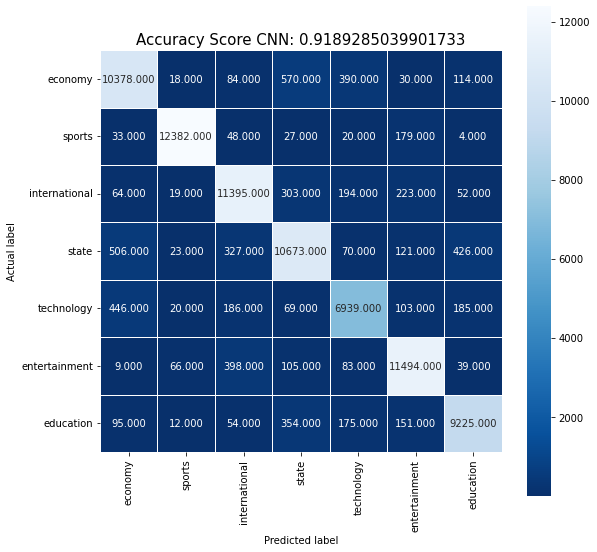

In [62]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

cm = metrics.confusion_matrix(test_labels,predictions)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'], 
                     columns = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'])

plt.figure(figsize=(9,9))
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score CNN: {0}'.format(loss_and_metrics[1])
plt.title(all_sample_title, size = 15);

report = pd.DataFrame(classification_report(y_true = test_labels, y_pred = predictions, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'sports','2':'international','3':'state','4':'technology','5':'entertainment','6':'education'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
display(report)